# Goal and Project

This project aims to utilise a wafer defect dataset to create a CNN that is able to take in a Silicon Wafer with defects, then classify which defects that wafer has. A wafer can also have many defects, so this is a multilabel classification problem. I dive into each step of the training and classification, then rigorously evaluate the model.

I will train two models, one normal ANN, and another more powerful CNN. The latter will be optimised using Keras Tuner, which is a powerful API that allows the user to perfectly tune model hyperparameters. The reason for traininng two models is to quantitatively describe how much better CNN's are compared to other basic models when it comes to image classification. This way, there is a numerical baseline, and so evaluations are more grounded.

The image dataset contains aroudn 38000 images of 52x52 pixel images. I will dive into the archietcture of both models in the notebook.

#Import Statements and Load in data


Here, I import the dataset and all relevant libraries to get started.

In [ ]:
import matplotlib.pyplot as plt
import keras
import math

In [ ]:
from numpy import load
import numpy as np
import pandas as pd

from keras import layers
from keras.losses import BinaryCrossentropy
from keras.metrics import Precision, Recall, F1Score

# Load the data
data = load('Wafer_Map_Datasets.npz')
lst = data.files

# Seeing shape and data


In [ ]:
np.shape(((data[lst[1]])))

(38015, 8)

This indicates we have 38015 images and 8 corresponding labels.

In [ ]:
np.shape((data[lst[0]]))

(38015, 52, 52)

This indates we have 38015 images, each with 52x52 pixel images

##Testing sample output of what one wafer looks like

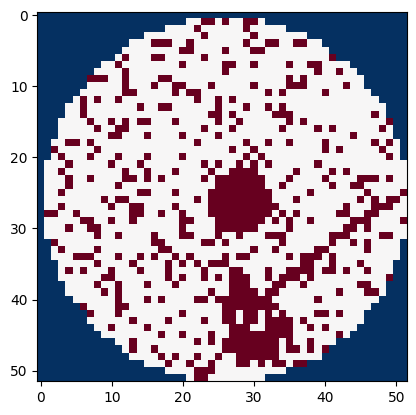

In [ ]:
#function for wafer image display
def show(x):
  plt.imshow(x,cmap='RdBu_r')

show(data[lst[0]][9000])


# Data Processing

In this section, my goal is to create data splits such that I am randomised sections of data to train, validate, and test my model.

In [ ]:
x = data[lst[0]]
y = data[lst[1]]
np.shape(x)

(38015, 52, 52)

In [ ]:
# Create a random permutation of indices
permutation = np.random.permutation(x.shape[0])

In [ ]:
# shuffle the data and labels using the same permutation to preserve labels
x = x[permutation]
y = y[permutation]

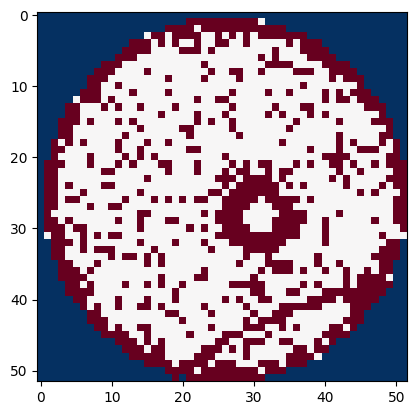

In [ ]:
#validating shuffle went well
show(x[88])

Using the library below, I split my data set.

In [ ]:
#splitting my data into testing, validation, and training
from sklearn.model_selection import train_test_split

# Split the data into training and temporary validation/test set
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.25, random_state=42)

# Split the temporary validation/test set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.4, random_state=42)

Note in this case that:

Training set: 75%
Validation set: 10%
Test set: 15%

# Model Training

To set a baseline or benchmark, I will be doing a standard feed forward model and recording the result. This will consist of just a small amount of layers with batch normalization between each for stability.

The second model will be an advanced CNN. I will see how much better the CNN does compared to this to see if it is worth the extra hassle!

In [ ]:
# @title Importing
#importing
from keras.losses import BinaryCrossentropy
from keras.metrics import Precision, Recall, F1Score
from keras import layers
import pandas
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import models

num_defect_types = 8

In [ ]:
# @title Plotting func
#plotting function of the model data
def plot_hist(x):
  pd.DataFrame(x.history).plot()
  plt.title("Training Summary")
  plt.xlabel("Epoch")
  plt.ylabel("Metric")
  plt.grid("on")
  plt.show()

## ANN

Below follows a very standard model. I use the ReLu function, build a couple of layers, followed by a sigmoid activation for the multi-label classification. I also utilise batch normalisation to not saturate gradients, help with regulisation, and overall stability.
I use the standard metrics - precision and recall - to help me see how my model is doing. This is standard for image classification and will be useful in setting a baseline of how this model is performing. Since this is not a CNN, I flatten the model.

In [ ]:
#flattening
x = x.reshape(len(x),52*52)
#building simple model with batch norm
model = keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(8, activation='sigmoid')
])

opt = keras.optimizers.Adam(learning_rate=0.001)
#standard metrics
metrics = [
    Precision(name='precision'),
    Recall(name='recall'),

]
#compiling
model.compile(loss=BinaryCrossentropy(), optimizer=opt, metrics=metrics)
#recording history of the fit
history2 = model.fit(x=x_train.reshape(len(x_train),52*52),
                    y=y_train,
                    validation_data=(x_val.reshape(len(x_val),52*52),y_val),
                    batch_size=128,
                    epochs=17)



Epoch 1/17
223/223 [==============================] - 6s 18ms/step - loss: 0.3285 - precision: 0.7433 - recall: 0.8560 - val_loss: 0.7005 - val_precision: 0.5982 - val_recall: 0.7750
Epoch 2/17
223/223 [==============================] - 4s 20ms/step - loss: 0.1237 - precision: 0.9298 - recall: 0.9225 - val_loss: 0.5433 - val_precision: 0.6775 - val_recall: 0.9398
Epoch 3/17
223/223 [==============================] - 3s 13ms/step - loss: 0.0852 - precision: 0.9515 - recall: 0.9429 - val_loss: 0.4997 - val_precision: 0.6467 - val_recall: 0.9352
Epoch 4/17
223/223 [==============================] - 3s 13ms/step - loss: 0.0643 - precision: 0.9638 - recall: 0.9566 - val_loss: 0.4341 - val_precision: 0.7050 - val_recall: 0.9645
Epoch 5/17
223/223 [==============================] - 3s 14ms/step - loss: 0.0494 - precision: 0.9727 - recall: 0.9675 - val_loss: 0.3735 - val_precision: 0.7339 - val_recall: 0.9307
Epoch 6/17
223/223 [==============================] - 4s 17ms/step - loss: 0.0387 - p

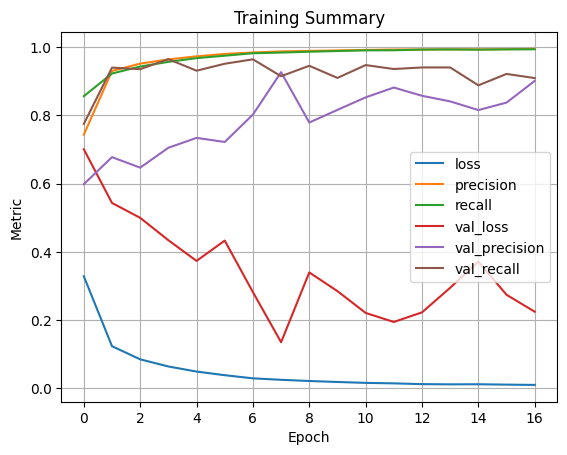

In [ ]:
plot_hist(history2)

## ANN Analysis

It is observed that the model overall behaves somewhat haphazardly, with the validation loss being quite noisy. The precision and recall seem to asymptote. My guess for this behaviour is that this model does not have enough parameters to generalise to the overall behaviour of what the defects are showing. I also think that the ideal amount of epochs should have been slighly less, as the model shows early signs of over fitting.

Overall, this is not the most optimal set up for this sort of problem, so excellent behaviour is not to be expected.



In [ ]:
loss, precision, recall = model.evaluate(x_test.reshape(len(x_test),52*52), y_test)
print(f"Test Loss: {np.round(loss,4):}")
print(f"Test Precision: {np.round(precision,4):}")
print(f"Test Recall: {np.round(recall,4):}")

119/119 [==============================] - 1s 8ms/step - loss: 0.2605 - precision: 0.8794 - recall: 0.8837
Test Loss: 0.2605
Test Precision: 0.8794
Test Recall: 0.8837


The model shows a reasonably good score compared to how simple it is! around 88% for both precision and recall, which shows that the model performs rather well.

This establishes that to get a reasonably working model, only a moderate amount of effort is involved. In the next section, we will see what a great amount of effort yields in accuracy.

In [ ]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               346240    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_2 (Bat  (None, 64)                2

# CNN


For the CNN, I will be using a much more involved architecture. This will be done through keras tuner. Keras tuner is part of the keras API and enables automated finding of specific hyperparameters. For example, I use it to tune how many layers and filters I should have. This is to get the optimal performance from the model. Additionally, it is also such that I do not have to conduct many iterations of trial and error to see the optimal amount of the aforementioned hyperparameters. This way, through defining the objective function, I can simply run it once and the model will have the exact right amount of hyperparameters. It is a much faster way, on net, to train this way -- especially since it cuts through all of the guesses at an effective architecture and calculates one.

In [ ]:
#installing keras tuner
!pip install keras-tuner -q

In [ ]:
#Checking shape
np.shape(x_train[0])

(52, 52)

Here, I defined a custom metric, F1 Score. The F1 score is a score used for CNNs specifically as it is an average of the most important parameters, recall and precision. While F1 Score is already within Keras, it is not yet usable on Keras Tuner, and I wanted to make sure I had the best eval.

Through setting my objective function to be consistently increasing the (validation) F1 Score, I am able to achieve a very robust model that is able to effectively perform across both metrics, not just one.



In [ ]:
from keras import backend as K

precision_obj = keras.metrics.Precision()
recall_obj = keras.metrics.Recall()
def fscore(y_true, y_pred):
    precision_obj.update_state(y_true, y_pred)
    recall_obj.update_state(y_true, y_pred)
    precision = precision_obj.result()
    recall = recall_obj.result()
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


##  Keras Tuner step

There are several things to point out:

 The architecture is a seqential model, but with no committed amount of filters. There is also no committed amount of kernel size or pooling size. This is essentially to allow the tuner to pick the right amount, and I define these factors (among others) as my hyperparameters, to be optimised within a specific range of values.

Dropout layers are also factors that I did not know whether to include or not and allowed the algorithm to make a decision here.

Essentially, Keras Tuner is able to take from the options I have and find the most ideal combination of them with respect to my optimisation function (F1 Score, validation set). It does this through randomly searching a combination of the choices of hyperpramaters, and comparing that model against the objective function. It does this continually until it finds a combination that delivers the highest amount.

In [ ]:
opt = keras.optimizers.legacy.Adam(learning_rate=0.001)
#Defining metrics
metrics = [
    Precision(name='precision'),
    Recall(name='recall'),
    'accuracy']
#defining CNN
def cnn(hp):
  #Defining the range of layers it can add
  num_conv = hp.Int("num_layers", 1, 5)

  model = Sequential()
  #Using a for loop where each loop is a layer, complete with filters, kernels, activations, etc.
  for i in range(num_conv):
    if i == 0:
      input_shape = (52, 52, 1)
      #Adding filters, kernels, and a ReLu activation, keeping padding the same
    model.add(Conv2D(filters=hp.Int(f'filters_{i}', min_value=8, max_value=64, step=4),

                         kernel_size=hp.Choice(f'kernel_size_{i}', [2,3,4]),

                         activation='relu',input_shape=(52, 52, 1),padding='same'))

    #Max Pooling after Convolution
    model.add(MaxPooling2D(pool_size=hp.Choice(f'pool_size{i}', [2, 3, 4]), padding='same'))
    #Adding dropout layers, if Tuner decides the model needs it
    if hp.Boolean(f'dropout_{i}'):
      model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.3)))

  model.add(Flatten())
  #Adding dense layers for classification
  model.add(layers.Dense(8, activation='sigmoid'))
#Compiling with loss optimised for multi-label classification
  model.compile(optimizer=opt,
                loss=BinaryCrossentropy(),
                metrics=[fscore,Precision(name='precision'),Recall(name='recall'),'accuracy' ])
  return model

In [ ]:
import keras_tuner

tuner = keras_tuner.RandomSearch(
    #setting the model
    hypermodel=cnn,
    #setting the objective func
    objective= keras_tuner.Objective('val_fscore', direction='max'),
    #how many trials it can run, and how many executions each
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    directory="/content/CNN-Final-Project",
    project_name="CNN-Final-Project",
)

In [ ]:
#this is the training step. It completed 5 trials, with 3 executions each. Each execution had 18 epochs.
tuner.search(x_train, y_train, epochs=18, validation_data=(x_val, y_val))

Trial 5 Complete [00h 09m 14s]
val_fscore: 0.8602210283279419

Best val_fscore So Far: 0.8602210283279419
Total elapsed time: 00h 35m 44s


Below is a summary of each trial where the model was trying to find the best model.

In [ ]:
tuner.results_summary()

Results summary
Results in /content/CNN-Final-Project/CNN-Final-Project
Showing 10 best trials
Objective(name="val_fscore", direction="max")

Trial 4 summary
Hyperparameters:
num_layers: 3
filters_0: 36
kernel_size_0: 2
pool_size0: 2
dropout_0: True
dropout_rate_0: 0.2299170289973647
filters_1: 44
kernel_size_1: 2
pool_size1: 2
dropout_1: True
filters_2: 20
kernel_size_2: 4
pool_size2: 4
dropout_2: False
dropout_rate_2: 0.11563494238605926
filters_3: 28
kernel_size_3: 4
pool_size3: 3
dropout_3: True
filters_4: 44
kernel_size_4: 2
pool_size4: 2
dropout_4: False
dropout_rate_1: 0.1344388508794433
dropout_rate_3: 0.16912263591984608
Score: 0.8602210283279419

Trial 3 summary
Hyperparameters:
num_layers: 5
filters_0: 12
kernel_size_0: 3
pool_size0: 3
dropout_0: True
dropout_rate_0: 0.28828276974899736
filters_1: 8
kernel_size_1: 4
pool_size1: 2
dropout_1: True
filters_2: 24
kernel_size_2: 4
pool_size2: 4
dropout_2: False
dropout_rate_2: 0.24408880676069777
filters_3: 40
kernel_size_3: 3
po

In [ ]:
#saving the best performing model
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
#summary of the best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 52, 52, 36)        180       
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 36)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 26, 26, 36)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 44)        6380      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 44)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 44)        0

Interestingly, the model in this case is actually smaller than the ANN! The Tuner only added 3 convolutional layers in total, 2 dropout layers, and added the corresponding pooling layers after each convolution.

The curious part here is that it was able to find a model that, although quite small, had just the right amount of filters to get a good score.

I suspect the Dropout layers only had to be added due to how many epochs I ran the tuner. My hypothesis is that if I had run the Tuner for less epochs in total, the model would not have required dropout layers at all. However, this run had exhusted my free compute credits so I could not run it again.

Also note that before the Dense layer with the Sigmoid, there is a flattening where the outptut turns into a 1 dimensional, 320 feature array. This is important as the sigmoid function needs to have a 1D input.

I suspect that the reason more layers were not added is because the convolutional layers would have decreased the resolution so much that it would have been more difficult to see what was happening. This is only a 52x52 pixel image afterall, and adding more layers with Max Pooling would have removed almost all of the dimensionality. This way, the model is able to have all layers meaningfully learn something while still being small. There is no need for the model to be bigger than it needs to be!

This is generally what I would have built had I done it without Keras Tuner. However, I would not have been able to get the exact number of Kernels, filters, and pooling amount exactly right like it did here. Evaluations will indicate precisely how "worth it" this additional step is.

##Model has been trained and saved.

In [ ]:
model = best_model  # Get model (Sequential, Functional Model, or Model subclass)
model.save('/content/CNNProject.keras')  # The file needs to end with the .keras extension

# Evals

Make sure to run the fscore function before loading

In [ ]:
model = keras.models.load_model('/content/CNNProject.keras',custom_objects={"fscore": fscore})
model.evaluate(x_test, y_test)

119/119 [==============================] - 9s 57ms/step - loss: 0.0314 - fscore: 0.9807 - precision: 0.9955 - recall: 0.9657 - accuracy: 0.6376


[0.031432222574949265,
 0.9806503057479858,
 0.9955477714538574,
 0.9656779170036316,
 0.637559175491333]

Immediately we can see that the model has incredibly high performance! The precision and recall are extraordinarily high, and this is on the test set, which it has never seen before. This entails the tuner performed exceptionally well and gave the model parameters that are superbly suited for the role.

In my opinion, using the tuner and a CNN is well worth the usage of the extra resources and time, simply because the performance is significantly better. In a high stakes application, like this sort of model, detecting wafers with defects at the production line is critical. My evaluation is not yet done, and I will be conducting further analysis beyond just these two numbers.

In [ ]:
y_pred = model.predict(x_test)
#convert to binary
y_pred = (y_pred > 0.5).astype(int)

119/119 [==============================] - 3s 27ms/step


## Confusion Matrix

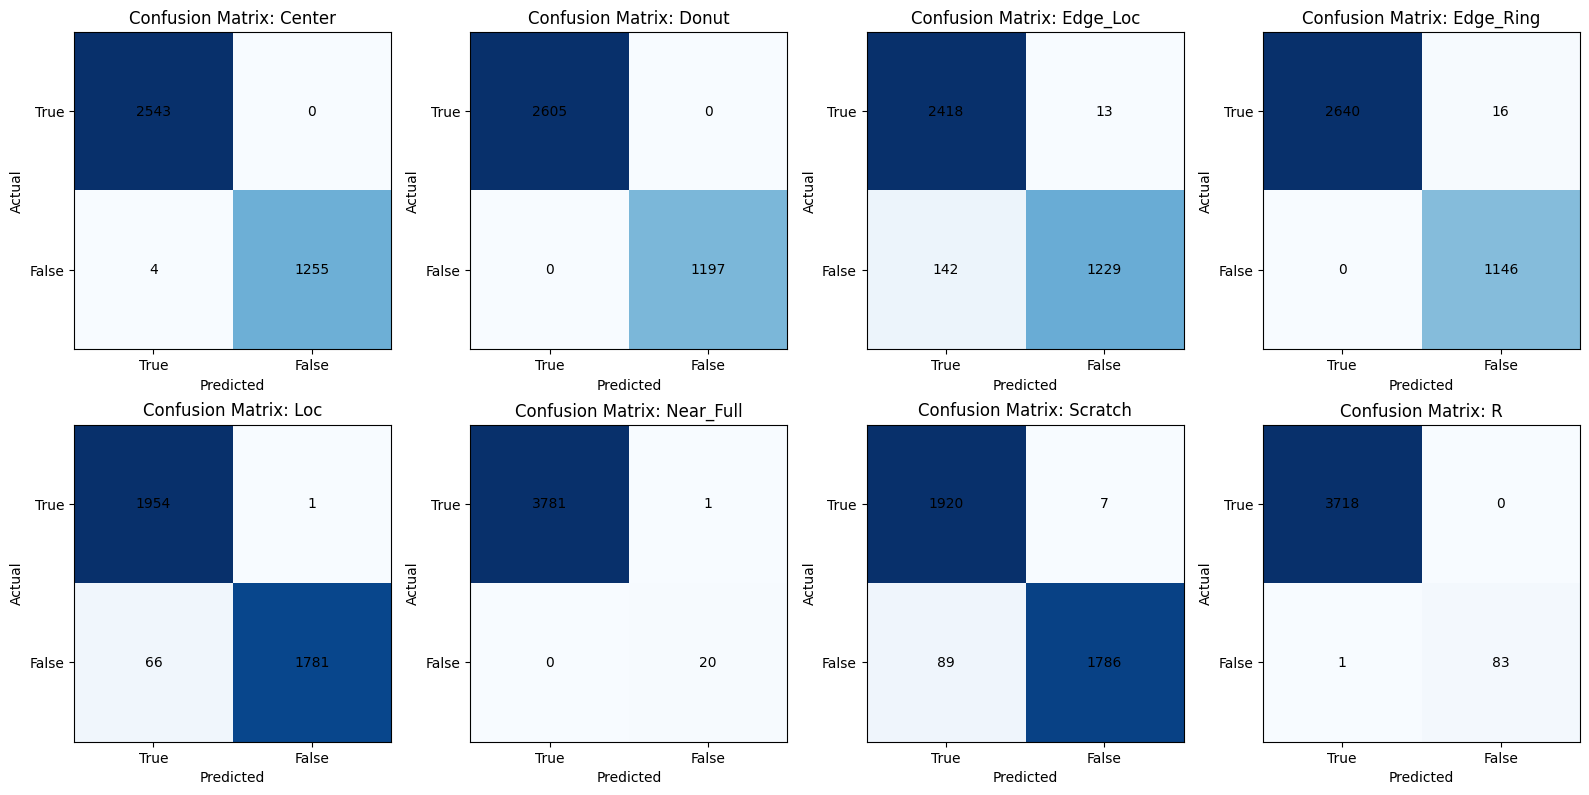

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, f1_score

#confusion matrix
cm = multilabel_confusion_matrix(y_test, y_pred)

# Define the label names
label_names = ['Center', 'Donut', 'Edge_Loc', 'Edge_Ring', 'Loc', 'Near_Full', 'Scratch', 'R']

# Plot the confusion matrix for each label
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axs = axs.flatten()
#plotting each result in a corner
for i, label in enumerate(label_names):
    tn, fp, fn, tp = cm[i].ravel()
    ax = axs[i]
    ax.set_title(f"Confusion Matrix: {label}")
    ax.imshow(cm[i], cmap='Blues')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['True', 'False'])
    ax.set_yticklabels(['True', 'False'])
    ax.text(0, 0, str(tn), color='black', ha='center', va='center')
    ax.text(1, 0, str(fp), color='black', ha='center', va='center')
    ax.text(0, 1, str(fn), color='black', ha='center', va='center')
    ax.text(1, 1, str(tp), color='black', ha='center', va='center')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
#plotting together
plt.tight_layout()
plt.show()

In [ ]:
# Calculate and print the F1 score for each class
for i, label in enumerate(label_names):
    f1 = f1_score(y_test[:, i], y_pred[:, i])
    print(f"F1 score for {label}: {f1:.3f}")

F1 score for Center: 0.998
F1 score for Donut: 1.000
F1 score for Edge_Loc: 0.941
F1 score for Edge_Ring: 0.993
F1 score for Loc: 0.982
F1 score for Near_Full: 0.976
F1 score for Scratch: 0.974
F1 score for R: 0.994


We can see that overall, the model performs well across the board. Results for all defects are above 0.94, and for most, above 0.97. The model perfectly generalised for the Donut defect, but had some trouble with the Edge Location defect. This is understandable since the edge location can be confused for the local defect, while the donut is incredibly distinct and hard to miss. Some classes did have more samples than others, but despite that being the case, they all performed well. For example there was 1000 instances of all defects, except for Random and Near_Full, but the model did well with them still.  


##Comparing predicted to True labels

This is just to see, using examples, how the model did.

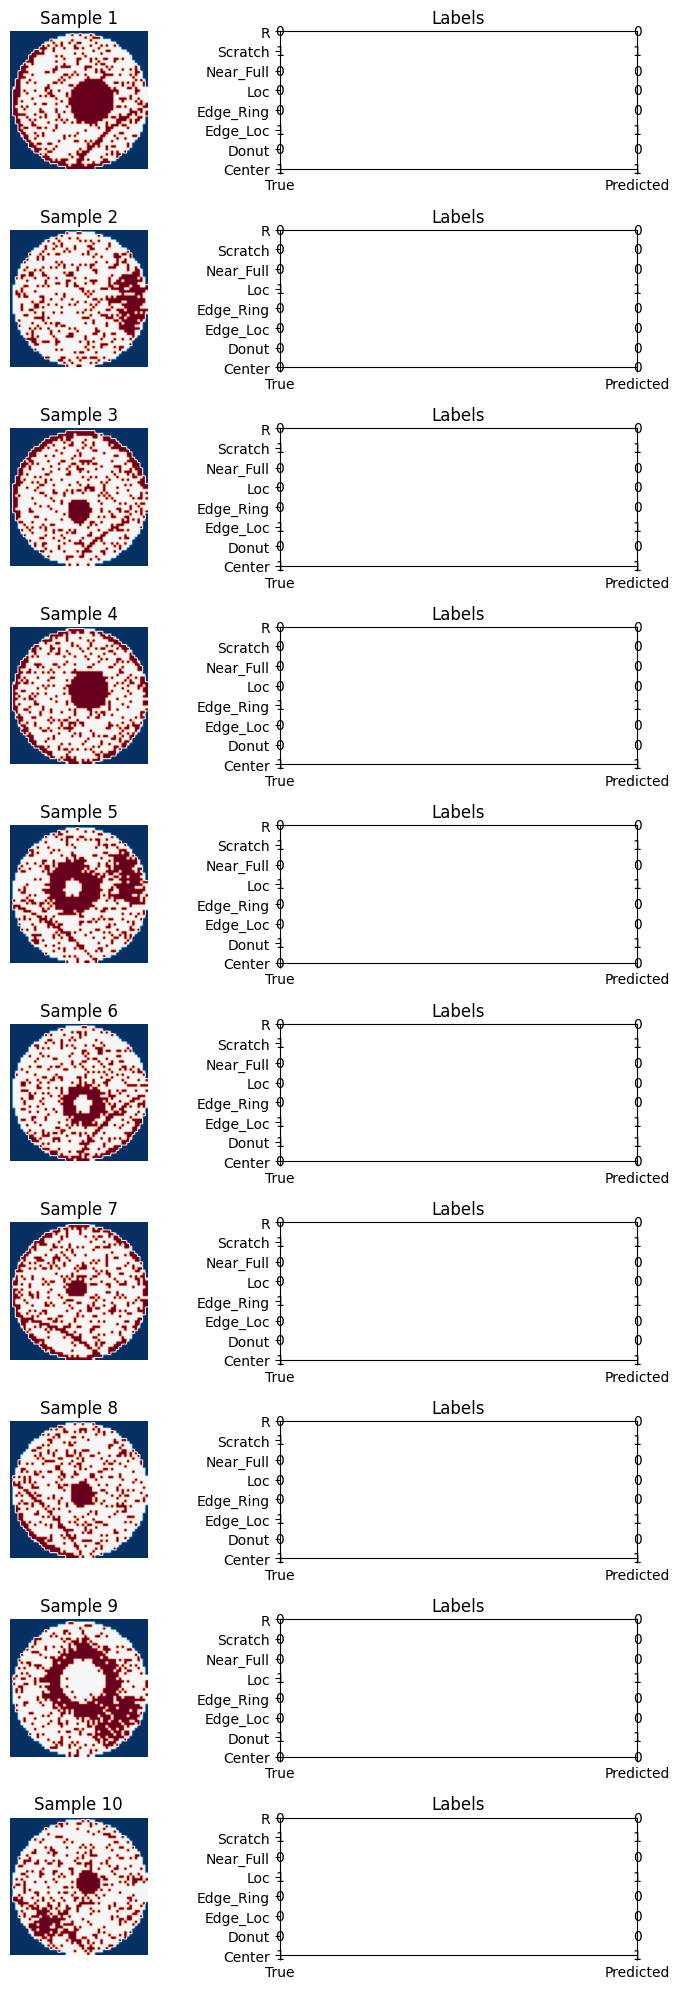

In [ ]:
# Define the label names
label_names = ['Center', 'Donut', 'Edge_Loc', 'Edge_Ring', 'Loc', 'Near_Full', 'Scratch','R']

# Select a few random samples from the test set
num_samples = 10  # Increase the number of samples to display
random_indices = np.random.choice(len(x_test), num_samples, replace=False)
samples = x_test[random_indices]
true_labels = y_test[random_indices]
predicted_labels = y_pred[random_indices]

# Visualize the samples along with their true and predicted labels
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(8, num_samples*2))
for i, ax in enumerate(axes):
    ax[0].imshow(samples[i], cmap='RdBu_r')
    ax[0].set_title(f'Sample {i+1}')
    ax[0].axis('off')
    ax[1].set_title('Labels')
    ax[1].set_yticks(range(len(true_labels[i])))
    ax[1].set_yticklabels([label_names[j] for j in range(len(true_labels[i]))])
    ax[1].set_xticks([0, 1])
    ax[1].set_xticklabels(['True', 'Predicted'])
    for j in range(len(true_labels[i])):
        ax[1].text(0, j, true_labels[i][j], ha='center', va='center', color='black')
        ax[1].text(1, j, predicted_labels[i][j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

As can be seen above, the model perfectly classifies these cases. While we already know the model does very well, it is good to validate that using examples. This does not tell us, however, what the model is focusing on. That will be the focus of another section!

## Misc Evals

Below is a number of various evals that are relevant to multi-label classification and allow for a more hollistic view of how the model is doing.


"The coverage error function computes the average number of labels that have to be included in the final prediction such that all true labels are predicted. This is useful if you want to know how many top-scored-labels you have to predict in average without missing any true one. The best value of this metrics is thus the average number of true labels"[2].

This will allow for a better understanding of how well the model is able to capture all the relevant labels for each instance, without having to predict an excessive number of labels.

In [ ]:
from sklearn.metrics import coverage_error
coverage_error(y_test, y_pred)

2.6486059968437665

In [ ]:
num_ones_per_list = [sum(inner_list) for inner_list in y_test]

# Calculate the average number of 1's
avg_num_ones = sum(num_ones_per_list) / len(y_test)

print("The average number of 1's in each list is:",np.round(avg_num_ones))

The average number of 1's in each list is: 2.0


This number is slightly higher than I would like it to be, though admittedly I have no reference to how close a great convergence error should look like. Note, though, that this means the model is very close (1 label off, if we round 2.6 to 3)

"Label ranking average precision (LRAP) averages over the samples the answer to the following question: for each ground truth label, what fraction of higher-ranked labels were true labels? This performance measure will be higher if you are able to give better rank to the labels associated with each sample. The obtained score is always strictly greater than 0, and the best value is 1. If there is exactly one relevant label per sample, label ranking average precision is equivalent to the mean reciprocal rank"[2].

In terms of the model, this allows for a clearer view of the model's ability to rank the predicted labels correctly for each instance. A higher LRAP score indicates that the model is more effective in assigning higher ranks or probabilities to the true labels associated with each sample, compared to the incorrect labels.

If this is high, then this is just another instance validating the model is performing well.

In [ ]:
from sklearn.metrics import label_ranking_average_precision_score
label_ranking_average_precision_score(y_test, y_pred)

0.9804054152785066

These two evaluations validate, from another perspective, how well the model is for this dataset and provide additional evidence it is robust for the purpose it is needed for.

# Saliency Map[3]

In [ ]:
copy = model
#removing the activations from the last layers to be able to read them
copy.layers[-1].activation = None
def saliency(x):
  with tf.GradientTape() as tape:
    #enabling gradient computation
      tensor_input = tf.convert_to_tensor(np.expand_dims(x, axis=0), dtype=tf.float32)
      tape.watch(tensor_input)
      #copies predictions
      preds = copy(tensor_input)
      #index of highest activations
      pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]
      #compute the gradients of the predicted class score with respect to the input image
      grads = tape.gradient(class_channel, tensor_input)
  heatmap = tf.squeeze(grads)
  #normalise
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  #convert to numpy array
  heatmap = heatmap.numpy()
  # Display heatmap
  plt.matshow(heatmap)
  plt.show()
  show(x)

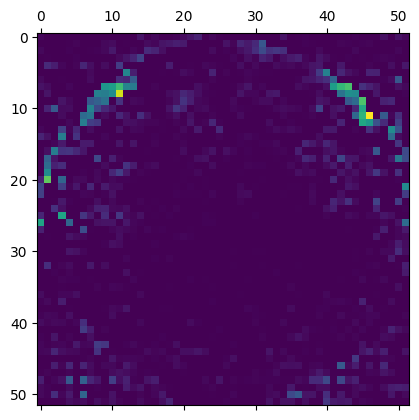

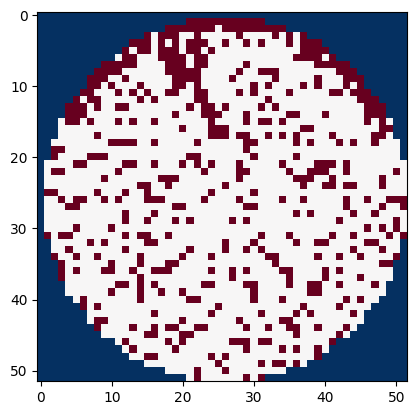

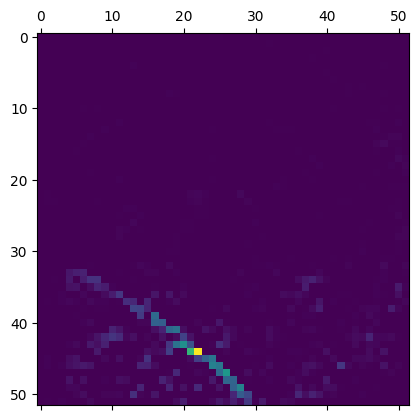

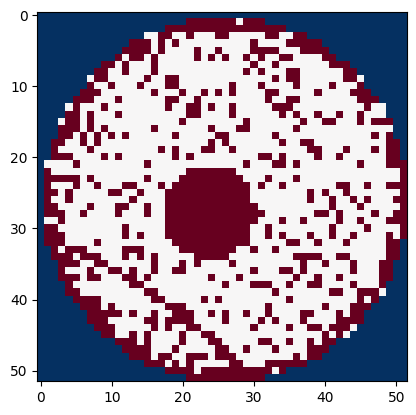

In [ ]:
#show saliency map of 4 wafers (note I selected a specific two wafers due to their ease of explainability)
for i in random_indices[2:4]:
  saliency(x[i])

The Saliency Map works by tracing the activations of the last layer, essentially seeing which parts of the wafer were most influential in the model's thinking.

Saliency maps allow for the ability to validate that the model is classifying based on the right feature, and not focusing an another arbitrary thing within the image to make a decision.

An extreme example of this would be a classifier between motorbikes and bikes. If all the motorbikes in the dataset are red, the model may see anything red as a motorbike and as such misunderstand what a motorbike is (or what we want it to think a motorbike is). It will then also classify anything not red as a motorbike and anything red as a bike. With a saliency map, you could hypothetically see that is focusing specifically on the red parts of your object and no more. It is a form of interpretability and allows for the validation of the model in terms of identifying the correct features relating to classification.

In the first case we see that the model specifically focuses on exactly where the defect is. This is a really good sign, since it is able to correctly identify the exact location of the defect. In the second case, it is interesting to note that the scratch defect completely overwhelmes all activations. This is an interesting example of where the model only focuses on one thing. Indeed this could be that the last layer is the layer most focused on scratch defects, or that the model rates them very highly. It is curious that the model is able to classify this wafer correctly, despite the last layer of activations mainly concerns the scratch. It could be that the previous layers already identified them and the last layer is looking at the scratch, but I am not sure.

Indeed, there perhaps are other techniques relating to Saliency Maps that allow for a clearer image of the models activations. Better normalisation and extraction of the gradients may allow for a small gap in the "lighting up" of the images, among other things. Nevertheless it is interesting to see how the model is "reading" the wafer. It focuses singularly on defects (there are no random activations outside of the wafer body, either) providing final indication of an extremely well trained model for the task.

# Conclusion

Overall, the use of Keras Tuner allowed for the training of an exceedingly effective model, way above what a basic ANN was able to achieve. The model recognises defects correctly in its activations, can correctly classify defects in almost all cases, and is small. The latter is especially important as it allows it to be stored on low storage micro-controllers that could be easily embedded within a production line, for example.

CNNs showcase clear superiority when it comes to image classification. The use of Keras Tuner allowed for optimal hyperparameters that achieved excellent numbers overall. I suspect that if I had taken a previous, pre-trained CNN, and fine tuned it on this data, that it would have not performed as well. This is becasue pre-trained CNNs are applicable to a variety of cases but may not be excellent at them, while this model is excellent in this specific case but I suspect would not do well in any other case.

Future steps would include better refining how the saliency fucntion works to alow for a clearer vision of all activations. Perhaps finidng a custom library to do the saliency maps in a quicker fashion would also be beneficial.
Something I would have done differently is to add more to the Tuner function such that the history and performance over epochs of all trials was better recorded. This would have allowed me to better analyse the training process over time, and see for myself how the model was performing over a specific execution.




#References


1 "Keras Tuner: Getting Started," Keras Documentation. [Online]. Available: https://keras.io/guides/keras_tuner/getting_started/. [Accessed: 23-Apr-2024].

2 L. Buitinck et al., "API design for machine learning software: experiences from the scikit-learn project," in ECML PKDD Workshop: Languages for Data Mining and Machine Learning, 2013, pp. 108–122.

3 M. Kumar, "Explainable AI Predictive Maintenance," 2024. [Online]. Available: https://github.com/mohan696matlab/Explainabel_AI_Predictive_Maintainance/blob/main/XAI_Saliency_CNN.ipynb. [Accessed: 23-Apr-2024].

